<a href="https://colab.research.google.com/github/kanstat/Apple-Leaf-Disease-Detection-Project/blob/main/fine_tunning_cnn_model.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Early diagnosis and accurate diagnosis of apple tree diseases (ATLDs) can control spread of infection, reduce the use of chemical fertilizers and pesticides, improve yields andapple quality, and maintaining healthy growth of apple cultivars. To improve precision and efficiency, an early ATLD diagnostic method based on deep convolutional neural network is suggested.
During my research, when I start to train a neural network from very scratch,  I realized that their are many problems comes during training a neural netwok  such as underfitting, overfitting, vanishing gradient,exploding gradient etc so, i am trying to find out possible solutions.

In [ ]:
# mounting google drive files for uploading dataset
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
# import neccessary libararies
import tensorflow as tf
from tensorflow.keras import models, layers
import matplotlib.pyplot as plt
from tensorflow.keras import regularizers


In [ ]:
#defining important parameters
Image_size = 256
Batch_size = 50
Channels =3
EPOCHS = 50

In [ ]:
dataset = tf.keras.preprocessing.image_dataset_from_directory("/content/drive/MyDrive/ALDD",
shuffle = True,
image_size = (Image_size,Image_size),
batch_size = Batch_size
)

Found 1664 files belonging to 5 classes.


In [ ]:
classnames = dataset.class_names
classnames

['Alternaria leaf spot', 'Brown spot', 'Gray spot', 'Healthy leaf', 'Rust']

(50, 256, 256, 3)
[3 2 4 1 2 0 1 1 4 1 0 4 3 0 3 1 3 1 3 3 0 4 2 2 0 4 0 0 3 2 3 0 4 1 0 4 4
 0 1 1 2 2 2 3 2 0 1 2 4 4]
(50, 256, 256, 3)
[3 2 4 1 2 0 1 1 4 1 0 4 3 0 3 1 3 1 3 3 0 4 2 2 0 4 0 0 3 2 3 0 4 1 0 4 4
 0 1 1 2 2 2 3 2 0 1 2 4 4]
(50, 256, 256, 3)
[3 2 4 1 2 0 1 1 4 1 0 4 3 0 3 1 3 1 3 3 0 4 2 2 0 4 0 0 3 2 3 0 4 1 0 4 4
 0 1 1 2 2 2 3 2 0 1 2 4 4]
(50, 256, 256, 3)
[3 2 4 1 2 0 1 1 4 1 0 4 3 0 3 1 3 1 3 3 0 4 2 2 0 4 0 0 3 2 3 0 4 1 0 4 4
 0 1 1 2 2 2 3 2 0 1 2 4 4]


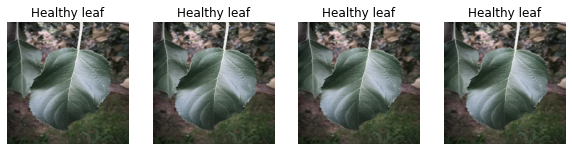

In [ ]:
#explore dataset
#to remove messed area
plt.figure(figsize=(10,10))
for image_batch, label_batch in dataset.take(1):
  for i in range(4):
    ax = plt.subplot(3,4,i+1)
    #to print first image
    plt.imshow(image_batch[0].numpy().astype("uint8"))
    plt.axis("off")
    #to give class name
    plt.title(classnames[label_batch[0]])
    print(image_batch.shape)
    print(label_batch.numpy())

In [ ]:
#80% == training, 10%==>test,
#10%==>validation
# a fuction to give train, test and validation size
def get_dataset_partition(dataset, train_split=0.8 , test_split=0.1 , val_split=0.1,shuffle =True,shuffle_size=10000):
  if shuffle:
    dataset = dataset.shuffle(shuffle_size,seed=12)
  dataset_size = len(dataset)
  train_size =int(dataset_size*train_split)
  val_size = int(dataset_size*val_split)
  train_ds =dataset.take(train_size)
  val_ds = dataset.skip(train_size).take(val_size)
  test_ds = dataset.skip(train_size).skip(val_size)


  return train_ds, test_ds, val_ds

In [ ]:
train_ds, test_ds,val_ds = get_dataset_partition(dataset)

In [ ]:
len(dataset)

34

In [ ]:
len(train_ds)

27

In [ ]:
len(test_ds)

4

In [ ]:
len(val_ds)

3

##Data Preprocessing

In [ ]:
#cache==>read the image from the disk for the next iteration when you need the same image, it will keep the image in the memory
#prefetch--> if you are using gpu or cpu, if gpu is busy in training prefetch will load the next set of batch from your disk,
# that will improve the performance
train_ds= train_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)
test_ds= test_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)
val_ds= val_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)

In [ ]:
#image preprocessing(scaling)
#we have rgb channels from 0-255 so we have to convert it b/w 0 and 1, devide it by 255
resize_and_rescale = tf.keras.Sequential([
                                        layers.experimental.preprocessing.Resizing(Image_size,Image_size),
                                        layers.experimental.preprocessing.Rescaling(1.0/255)
                                        ])

In [ ]:
#data augumentation
data_aug = tf.keras.Sequential([
                     layers.experimental.preprocessing.RandomFlip("horizontal_and_vertical"),
                     layers.experimental.preprocessing.RandomRotation(0.2),
])

##Model with l2 regularisation Layer

In [ ]:
Input_shape =(Batch_size,Image_size,Image_size,Channels)
n_classes = 5
model = models.Sequential([
                           resize_and_rescale,
                           data_aug,
                           layers.Conv2D(32,(3,3),activation='relu',input_shape = Input_shape,activity_regularizer=regularizers.l2(1e-3)),
                           layers.MaxPooling2D((2,2)),
                           layers.Conv2D(64,kernel_size=(3,3),activation='relu',activity_regularizer=regularizers.l2(1e-3)),
                           layers.MaxPooling2D((2,2)),
                           layers.Conv2D(64,kernel_size=(3,3),activation='relu',activity_regularizer=regularizers.l2(1e-3)),
                           layers.MaxPooling2D((2,2)),
                           layers.Conv2D(64,(3,3),activation='relu',activity_regularizer=regularizers.l2(1e-3)),
                           layers.MaxPooling2D((2,2)),
                            layers.Conv2D(64,(3,3),activation='relu',activity_regularizer=regularizers.l2(1e-3)),
                           layers.MaxPooling2D((2,2)),
                           layers.Conv2D(64,(3,3),activation='relu',activity_regularizer=regularizers.l2(1e-3)),
                           layers.MaxPooling2D((2,2)),
                          layers.Flatten(),
                           layers.Dense(64,activation='relu'),
                          layers.Dense(64,activation='softmax')

])
model.build(input_shape=Input_shape)

In [ ]:
model.summary()

Model: "sequential_8"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 sequential_6 (Sequential)   (50, 256, 256, 3)         0         
                                                                 
 sequential_7 (Sequential)   (50, 256, 256, 3)         0         
                                                                 
 conv2d_24 (Conv2D)          (50, 254, 254, 32)        896       
                                                                 
 max_pooling2d_24 (MaxPoolin  (50, 127, 127, 32)       0         
 g2D)                                                            
                                                                 
 conv2d_25 (Conv2D)          (50, 125, 125, 64)        18496     
                                                                 
 max_pooling2d_25 (MaxPoolin  (50, 62, 62, 64)         0         
 g2D)                                                 

In [ ]:
#Compiling the Model
#We use adam Optimizer, SparseCategoricalCrossentropy for losses, accuracy as a metric
model.compile(optimizer='adam',
              loss = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),
              metrics = 'accuracy'
              )

In [ ]:
history = model.fit(
           train_ds,
           epochs=EPOCHS,
           batch_size= Batch_size,
           verbose = 1,
          validation_data = val_ds
)

Epoch 1/50
27/27 [==============================] - 14s 327ms/step - loss: 10.1483 - accuracy: 0.2237 - val_loss: 2.3127 - val_accuracy: 0.2067
Epoch 2/50
27/27 [==============================] - 4s 149ms/step - loss: 1.9504 - accuracy: 0.2341 - val_loss: 1.8287 - val_accuracy: 0.2200
Epoch 3/50
27/27 [==============================] - 4s 149ms/step - loss: 1.7528 - accuracy: 0.2178 - val_loss: 1.7355 - val_accuracy: 0.2533
Epoch 4/50
27/27 [==============================] - 4s 148ms/step - loss: 1.6946 - accuracy: 0.2741 - val_loss: 1.6830 - val_accuracy: 0.2533
Epoch 5/50
27/27 [==============================] - 4s 149ms/step - loss: 1.6218 - accuracy: 0.3148 - val_loss: 1.5400 - val_accuracy: 0.3667
Epoch 6/50
27/27 [==============================] - 4s 149ms/step - loss: 1.3656 - accuracy: 0.4911 - val_loss: 1.3057 - val_accuracy: 0.5133
Epoch 7/50
27/27 [==============================] - 4s 149ms/step - loss: 1.0965 - accuracy: 0.6244 - val_loss: 1.1489 - val_accuracy: 0.5600
Epoc

In [ ]:
scores = model.evaluate(test_ds)

4/4 [==============================] - 4s 61ms/step - loss: 0.5156 - accuracy: 0.8500


In [ ]:
history

In [ ]:
history.params

{'epochs': 50, 'steps': 27, 'verbose': 1}

In [ ]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

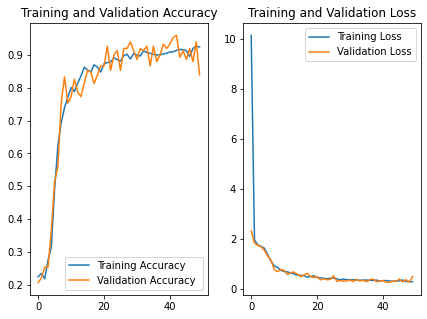

In [ ]:
#loss, accuracy, val loss etc are a python list containing values of loss, accuracy etc at the end of each epoch
plt.figure(figsize = (7,5))
plt.subplot(1,2,1)
plt.plot(range(EPOCHS),acc,label="Training Accuracy")
plt.plot(range(EPOCHS),val_acc,label="Validation Accuracy ")
plt.legend(loc = 'lower right')
plt.title('Training and Validation Accuracy')


plt.subplot(1, 2, 2)
plt.plot(range(EPOCHS), loss, label='Training Loss')
plt.plot(range(EPOCHS), val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

first image to predict
actual label: Alternaria leaf spot
predicted label: Alternaria leaf spot


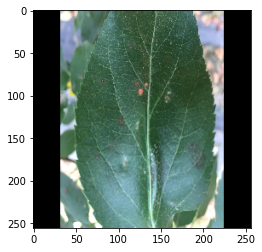

In [ ]:
#Run prediction on a sample image
import numpy as np
for images_batch, labels_batch in test_ds.take(1):
    
    first_image = images_batch[0].numpy().astype('uint8')
    first_label = labels_batch[0].numpy()
    
    print("first image to predict")
    plt.imshow(first_image)
    print("actual label:",classnames[first_label])
    
    batch_prediction = model.predict(images_batch)
    print("predicted label:",classnames[np.argmax(batch_prediction[0])])

##BUILDING A MODEL WITH DROPUT REGULARISATION

###Dropout is a regularization method that approximates training a large number of neural networks with different architectures in parallel.
###During training, some number of layer outputs are randomly ignored or “dropped out.” This has the effect of making the layer look-like and be treated-like a layer with a different number of nodes and connectivity to the prior layer. In effect, each update to a layer during training is performed with a different “view” of the configured layer.

In [ ]:
import tensorflow as tf
from tensorflow import keras

In [ ]:
#building a model using cnn or model architecture
Input_shape =(Batch_size,Image_size,Image_size,Channels)
n_classes = 5
model = models.Sequential([
                           resize_and_rescale,
                           data_aug,
                           layers.Conv2D(32,(3,3),activation='relu',input_shape = Input_shape),
                           layers.MaxPooling2D((2,2)),
                           keras.layers.Dropout(0.3),
                           layers.Conv2D(64,kernel_size=(3,3),activation='relu'),
                           layers.MaxPooling2D((2,2)),
                           keras.layers.Dropout(0.3),
                           layers.Conv2D(64,kernel_size=(3,3),activation='relu'),
                           layers.MaxPooling2D((2,2)),
                           keras.layers.Dropout(0.3),
                           layers.Conv2D(64,(3,3),activation='relu'),
                           layers.MaxPooling2D((2,2)),
                            keras.layers.Dropout(0.3),
                            layers.Conv2D(64,(3,3),activation='relu'),
                           layers.MaxPooling2D((2,2)),
                           keras.layers.Dropout(0.3),
                           layers.Conv2D(64,(3,3),activation='relu'),
                           layers.MaxPooling2D((2,2)),
                           keras.layers.Dropout(0.3),
                          layers.Flatten(),
                           layers.Dense(64,activation='relu'),
                        layers.Dense(64,activation='softmax')

])
model.build(input_shape=Input_shape)

In [ ]:
model.summary()

Model: "sequential_10"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 sequential_6 (Sequential)   (None, 256, 256, 3)       0         
                                                                 
 sequential_7 (Sequential)   (None, 256, 256, 3)       0         
                                                                 
 conv2d_36 (Conv2D)          (50, 254, 254, 32)        896       
                                                                 
 max_pooling2d_36 (MaxPoolin  (50, 127, 127, 32)       0         
 g2D)                                                            
                                                                 
 dropout_18 (Dropout)        (50, 127, 127, 32)        0         
                                                                 
 conv2d_37 (Conv2D)          (50, 125, 125, 64)        18496     
                                                     

In [ ]:
#Compiling the Model
#We use adam Optimizer, SparseCategoricalCrossentropy for losses, accuracy as a metric
model.compile(optimizer='adam',
              loss = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),
              metrics = 'accuracy'
              )

In [ ]:
history = model.fit(
           train_ds,
           epochs=EPOCHS,
           batch_size= Batch_size,
           verbose = 1,
          validation_data = val_ds
)

Epoch 1/50
27/27 [==============================] - 5s 127ms/step - loss: 2.2567 - accuracy: 0.2148 - val_loss: 2.9153 - val_accuracy: 0.2667
Epoch 2/50
27/27 [==============================] - 3s 121ms/step - loss: 1.5236 - accuracy: 0.3481 - val_loss: 2.5791 - val_accuracy: 0.4733
Epoch 3/50
27/27 [==============================] - 3s 122ms/step - loss: 1.3427 - accuracy: 0.4111 - val_loss: 2.5269 - val_accuracy: 0.4667
Epoch 4/50
27/27 [==============================] - 3s 123ms/step - loss: 1.2543 - accuracy: 0.4474 - val_loss: 2.8266 - val_accuracy: 0.5400
Epoch 5/50
27/27 [==============================] - 3s 122ms/step - loss: 1.2418 - accuracy: 0.4333 - val_loss: 2.1269 - val_accuracy: 0.4400
Epoch 6/50
27/27 [==============================] - 3s 122ms/step - loss: 1.1801 - accuracy: 0.4822 - val_loss: 1.7523 - val_accuracy: 0.7067
Epoch 7/50
27/27 [==============================] - 3s 121ms/step - loss: 0.9102 - accuracy: 0.6222 - val_loss: 1.4252 - val_accuracy: 0.5733
Epoch 

In [ ]:
scores = model.evaluate(test_ds)

4/4 [==============================] - 0s 55ms/step - loss: 0.2495 - accuracy: 0.9150


In [ ]:
history

In [ ]:
history.params

{'epochs': 50, 'steps': 27, 'verbose': 1}

In [ ]:
history.history.keys()

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])

In [ ]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

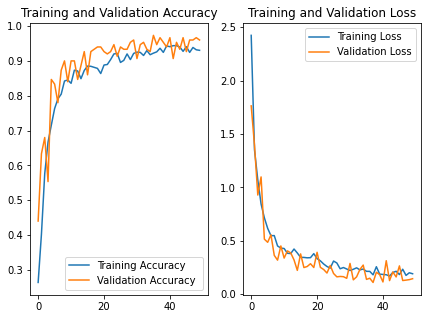

In [ ]:
#loss, accuracy, val loss etc are a python list containing values of loss, accuracy etc at the end of each epoch
plt.figure(figsize = (7,5))
plt.subplot(1,2,1)
plt.plot(range(EPOCHS),acc,label="Training Accuracy")
plt.plot(range(EPOCHS),val_acc,label="Validation Accuracy ")
plt.legend(loc = 'lower right')
plt.title('Training and Validation Accuracy')


plt.subplot(1, 2, 2)
plt.plot(range(EPOCHS), loss, label='Training Loss')
plt.plot(range(EPOCHS), val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

first image to predict
actual label: Rust
predicted label: Rust


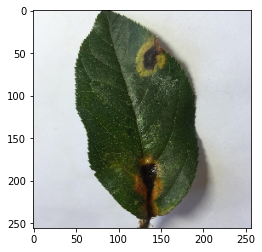

In [ ]:
#Run prediction on a sample image
import numpy as np
for images_batch, labels_batch in test_ds.take(1):
    
    first_image = images_batch[0].numpy().astype('uint8')
    first_label = labels_batch[0].numpy()
    
    print("first image to predict")
    plt.imshow(first_image)
    print("actual label:",classnames[first_label])
    
    batch_prediction = model.predict(images_batch)
    print("predicted label:",classnames[np.argmax(batch_prediction[0])])